In [10]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.sparse as scilin
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import math
import numpy.linalg as la
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
def distance_mat(X, n_neighbors=6):
    """
    Compute the square distance matrix using Euclidean distance
    :param X: Input data, a numpy array of shape (img_height, img_width)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (img_height, img_height), numpy array of shape (img_height, n_neighbors)
    """
    def dist(a, b):
        return np.sqrt(sum((a - b)**2))

    # Compute full distance matrix
    distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

    # Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbors = np.zeros_like(distances)
    sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = distances[k,i]
    return neighbors, sort_distances

In [3]:
def center(K):
    """
    Method to center the distance matrix
    :param K: numpy array of shape mxm
    :return: numpy array of shape mxm
    """
    n_samples = K.shape[0]

    # Mean for each row/column
    meanrows = np.sum(K, axis=0) / n_samples
    meancols = (np.sum(K, axis=1)/n_samples)[:, np.newaxis]

    # Mean across all rows (entire matrix)
    meanall = meanrows.sum() / n_samples

    K -= meanrows
    K -= meancols
    K += meanall
    return K

In [4]:
def mds(data, n_components=2):
    """
    Apply multidimensional scaling (aka Principal Coordinates Analysis)
    :param data: nxn square distance matrix
    :param n_components: number of components for projection
    :return: projected output of shape (n_components, n)
    """

    # Center distance matrix
    center(data)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_val_cov, eig_vec_cov = np.linalg.eig(data)
    eig_pairs = [
        (np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))
    ]

    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_pairs = np.array(eig_pairs)
    matrix_w = np.hstack(
        [eig_pairs[i, 1].reshape(data.shape[1], 1) for i in range(n_components)]
    )

    # Return samples in new subspace
    return matrix_w

In [5]:
def isomap(data, n_components=2, n_neighbors=6, dist=False):
    """
    Dimensionality reduction with isomap algorithm
    :param data: input image matrix of shape (n,m) if dist=False, square distance matrix of size (n,n) if dist=True
    :param n_components: number of components for projection
    :param n_neighbors: number of neighbors for distance matrix computation
    :param dist: boolean indicating the data type
    :return: Projected output of shape (n_components, n)
    """
    if not dist:
        # Compute distance matrix
        data, _ = distance_mat(data, n_neighbors)

    # Compute shortest paths from distance matrix
    from sklearn.utils.graph import graph_shortest_path
    graph = graph_shortest_path(data, directed=False)
    graph = -0.5 * (graph ** 2)

    # Return the MDS projection on the shortest paths graph
    return mds(graph, n_components)

In [6]:
def show(transform, data, output=None):
    '''
        size of transform : (n, 2)
        size of data : (n, 784)
        '''
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(transform[:, 0], transform[:, 1])
    for x0, y0, img in zip(transform[:, 0], transform[:, 1], data.reshape((-1, 28, 28), order='F')):
        ab = AnnotationBbox(OffsetImage(img, zoom=0.4, cmap='gray'), (x0, y0), frameon=False)
        ax.add_artist(ab)

    if output is None:
        plt.show()
    else:
        plt.savefig(output)


In [12]:
data = np.load("../data/digits-labels.npz")

# Select columns of five
d = data['d']
l = data['l']
five_idx = np.argwhere(l == 6)
d_fives = d[:, five_idx].squeeze().T

In [13]:
# Perform Isomap
distances, neighbors_idx = distance_mat(d_fives)
transform_isomap = isomap(distances, dist=True)

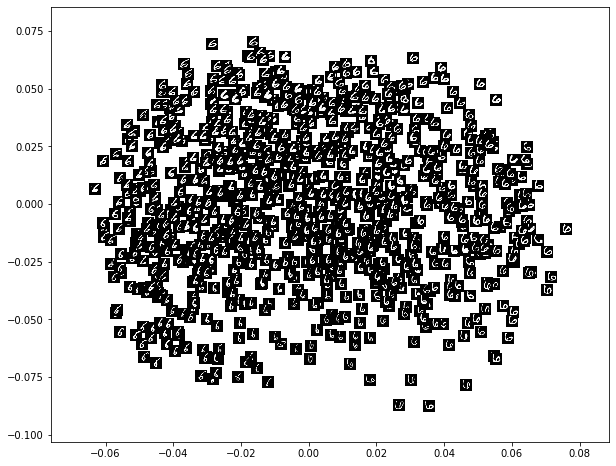

In [14]:
show(transform_isomap, d_fives)